# Regression Deep Learning Model for [PROJECT NAME] Using TensorFlow Version 8
### David Lowe
### October 13, 2020

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a predictive model using various machine learning algorithms and to document the end-to-end steps using a template. The [PROJECT NAME] dataset is a regression situation where we are trying to predict the value of a continuous variable.

INTRODUCTION: [Sample Paragraph - The purpose of the analysis is to predict the housing values in the suburbs of Boston by using the home sale transaction history.]

ANALYSIS: [Sample Paragraph - The performance of the baseline model achieved a root mean squared error (RMSE) of 7.67 after 50 epochs using the training dataset. After tuning the hyperparameters, the best model processed the validation dataset with an RMSE of 2.66. Furthermore, the final model processed the test dataset with an RMSE of 2.66, which was consistent with the training/tuning phase.]

CONCLUSION: [Sample Paragraph - In this iteration, the best TensorFlow model appeared to be suitable for modeling this dataset. We should consider experimenting with TensorFlow for further modeling.]

Dataset Used: [PROJECT NAME] Dataset

Dataset ML Model: Regression modeling with [numerical | categorical] attributes

Dataset Reference: [https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.data]

One potential source of performance benchmarks: [https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/]

A deep-learning modeling project generally can be broken down into five major tasks:

1. Prepare Environment
2. Summarize and Visualize Data
3. Pre-process Data
4. Train and Evaluate Models
5. Finalize Model and Present Analysis

# Task 1 - Prepare Environment

In [1]:
# Install the packages to support accessing environment variable and SQL databases
# !pip install python-dotenv PyMySQL boto3

In [2]:
# Retrieve GPU configuration information from Colab
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#     print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
#     print('and then re-execute this cell.')
# else:
#     print(gpu_info)

In [3]:
# Retrieve memory configuration information from Colab
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

# if ram_gb < 20:
#     print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
#     print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
#     print('re-execute this cell.')
# else:
#     print('You are using a high-RAM runtime!')

In [4]:
# Direct Colab to use TensorFlow v2
# %tensorflow_version 2.x

In [5]:
# Retrieve CPU information from the system
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 4


## 1.a) Load libraries and modules

In [6]:
# Set the random seed number for reproducible results
seedNum = 888

In [7]:
# Load libraries and packages
import random
random.seed(seedNum)
import numpy as np
np.random.seed(seedNum)
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import boto3
import math
from datetime import datetime
from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
# from imblearn.pipeline import Pipeline
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler
import tensorflow as tf
tf.random.set_seed(seedNum)
from tensorflow import keras

## 1.b) Set up the controlling parameters and functions

In [8]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
n_jobs = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set Pandas options
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 140)

# Set the percentage sizes for splitting the dataset
test_set_size = 0.2
val_set_size = 0.25

# Set the number of folds and iterations for cross validation
n_folds = 5
n_iterations = 2

# Set various default modeling parameters
default_loss = 'mean_squared_error'
default_metrics = [tf.keras.metrics.RootMeanSquaredError()]
default_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
default_kernel_init = tf.keras.initializers.GlorotUniform(seed=seedNum)
default_epoch = 50
default_batch = 16

# Define the labels to use for graphing the data
train_metric = "loss"
validation_metric = "val_loss"

# Check the number of GPUs accessible through TensorFlow
print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

Num GPUs Available:  0


In [ ]:
# Set up the parent directory location for loading the dotenv files
# useColab = False
# if useColab:
#     # Mount Google Drive locally for storing files
#     from google.colab import drive
#     drive.mount('/content/gdrive')
#     gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
#     env_path = '/content/gdrive/My Drive/Colab Notebooks/'
#     dotenv_path = env_path + "python_script.env"
#     load_dotenv(dotenv_path=dotenv_path)

# Set up the dotenv file for retrieving environment variables
# useLocalPC = False
# if useLocalPC:
#     env_path = "/Users/david/PycharmProjects/"
#     dotenv_path = env_path + "python_script.env"
#     load_dotenv(dotenv_path=dotenv_path)

In [9]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [10]:
# Reset the random number generators
def reset_random(x):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [11]:
if notifyStatus: status_notify('(AutoKeras Regression) Task 1 - Prepare Environment has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

## 1.c) Load Dataset

In [13]:
dataset_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data'
colNames = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV']
Xy_original = pd.read_csv(dataset_path, names=colNames, delim_whitespace=True, header=None)

# Take a peek at the dataframe after the import
Xy_original.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
5,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222.0,18.7,394.12,5.21,28.7
6,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311.0,15.2,395.60,12.43,22.9
7,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311.0,15.2,396.90,19.15,27.1
8,0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311.0,15.2,386.63,29.93,16.5
9,0.17004,12.5,7.87,0,0.524,6.004,85.9,6.5921,5,311.0,15.2,386.71,17.10,18.9


In [14]:
Xy_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [15]:
Xy_original.describe()

Series([], dtype: int64)

In [16]:
# Surface the features that have NaNs
null_counts = Xy_original.isnull().sum()
if null_counts.sum() > 0 :
    print(null_counts[null_counts > 0])
print('Total number of NaN in the dataframe:', null_counts.sum())

Total number of NaN in the dataframe:  0


## 1.d) Data Cleaning

In [17]:
# Standardize the class column to the name of targetVar if required
# Xy_original = Xy_original.rename(columns={'MEDV': 'targetVar'})

# Dropping features
# Xy_original.drop(columns=['attribute_name'], inplace=True)

# Impute missing values
# Xy_original['col_name'].fillna('someValue', inplace=True)
# Xy_original['attribute_name'].fillna(value=Xy_original['attribute_name'].median(), inplace=True)

# Convert columns from one data type to another
# Xy_original.column_name = Xy_original.column_name.astype('int')
# Xy_original.column_name = Xy_original.column_name.astype('category')

# Take a peek at the dataframe after the cleaning
Xy_original.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,targetVar
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
5,0.02985,0.0,2.18,0.0,0.458,6.430,58.7,6.0622,3.0,222.0,18.7,394.12,5.21,28.7
6,0.08829,12.5,7.87,0.0,0.524,6.012,66.6,5.5605,5.0,311.0,15.2,395.60,12.43,22.9
7,0.14455,12.5,7.87,0.0,0.524,6.172,96.1,5.9505,5.0,311.0,15.2,396.90,19.15,27.1
8,0.21124,12.5,7.87,0.0,0.524,5.631,100.0,6.0821,5.0,311.0,15.2,386.63,29.93,16.5
9,0.17004,12.5,7.87,0.0,0.524,6.004,85.9,6.5921,5.0,311.0,15.2,386.71,17.10,18.9


In [18]:
Xy_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   CRIM       506 non-null    float64
 1   ZN         506 non-null    float64
 2   INDUS      506 non-null    float64
 3   CHAS       506 non-null    float64
 4   NOX        506 non-null    float64
 5   RM         506 non-null    float64
 6   AGE        506 non-null    float64
 7   DIS        506 non-null    float64
 8   RAD        506 non-null    float64
 9   TAX        506 non-null    float64
 10  PTRATIO    506 non-null    float64
 11  B          506 non-null    float64
 12  LSTAT      506 non-null    float64
 13  targetVar  506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


In [19]:
Xy_original.describe()

Series([], dtype: int64)

In [20]:
# Surface the features that have NaNs
null_counts = Xy_original.isnull().sum()
if null_counts.sum() > 0 :
    print(null_counts[null_counts > 0])
print('Total number of NaN in the dataframe:', null_counts.sum())

Total number of NaN in the dataframe:  0


## 1.e) Splitting Data into Sets

In [21]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(Xy_original.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = totCol

In [22]:
# We create attribute-only and target-only datasets (X_original and y_original)
# for various visualization and cleaning/transformation operations

if targetCol == totCol:
    X_original = Xy_original.iloc[:,0:totAttr]
    y_original = Xy_original.iloc[:,totAttr]
else:
    X_original = Xy_original.iloc[:,1:totCol]
    y_original = Xy_original.iloc[:,0]

print("Xy_original.shape: {} X_original.shape: {} y_original.shape: {}".format(Xy_original.shape, X_original.shape, y_original.shape))

Xy_original.shape: (506, 14) X_original.shape: (506, 13) y_original.shape: (506,)


In [ ]:
# Split the data further into training and test datasets
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_original, y_original, test_size=test_set_size, stratify=y_original, random_state=seedNum)
print("X_train_df.shape: {} y_train_df.shape: {}".format(X_train_df.shape, y_train_df.shape))
print("X_test_df.shape: {} y_test_df.shape: {}".format(X_test_df.shape, y_test_df.shape))

In [ ]:
if notifyStatus: status_notify('(AutoKeras Regression) Task 1 - Prepare Environment completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 2 - Summarize and Visualize Data

In [ ]:
if notifyStatus: status_notify('(AutoKeras Regression) Task 2 - Summarize and Visualize Data has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [23]:
# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 4
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = dispCol*4
fig_size[1] = dispRow*4
plt.rcParams["figure.figsize"] = fig_size

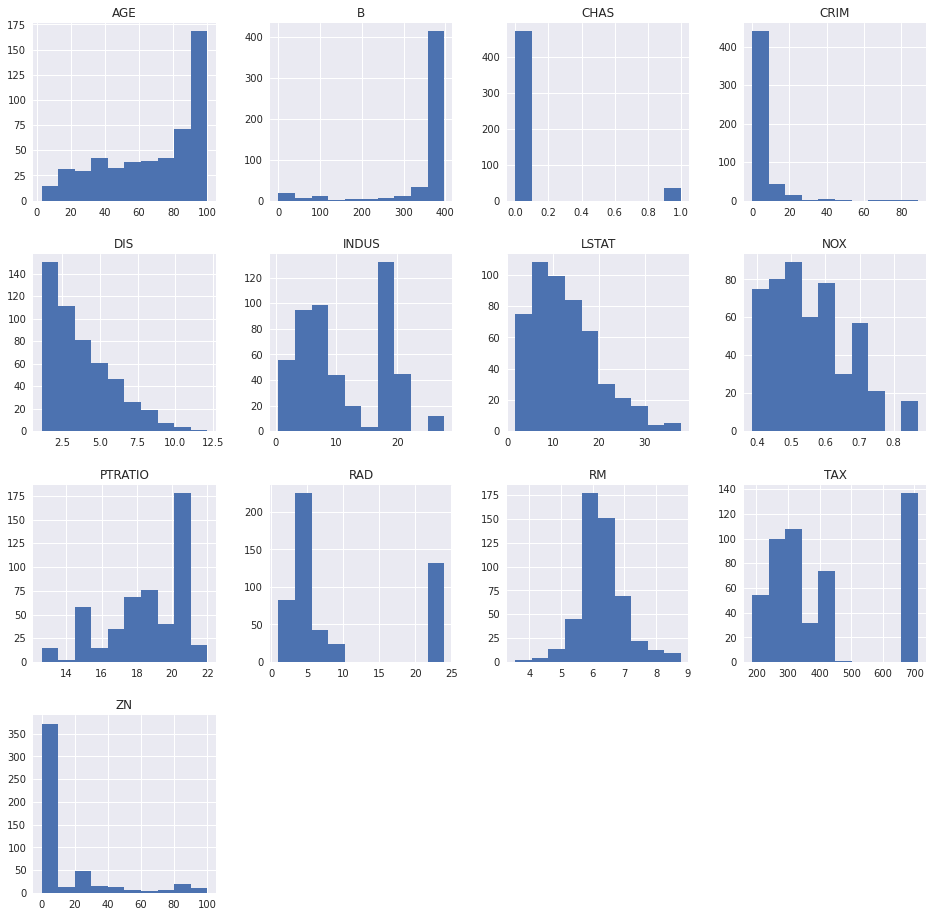

In [24]:
# Histograms for each attribute
X_train_df.hist(layout=(dispRow,dispCol))
plt.show()

In [25]:
# Box and Whisker plot for each attribute
X_train_df.plot(kind='box', subplots=True, layout=(dispRow,dispCol))
plt.show()

Columns to scale are: ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
       CRIM        ZN     INDUS      CHAS       NOX        RM       AGE       DIS       RAD       TAX   PTRATIO         B     LSTAT
0 -0.419782  0.284830 -1.287909 -0.272599 -0.144217  0.413672 -0.120013  0.140214 -0.982843 -0.666608 -1.459000  0.441052 -1.075562
1 -0.417339 -0.487722 -0.593381 -0.272599 -0.740262  0.194274  0.367166  0.557160 -0.867883 -0.987329 -0.303094  0.441052 -0.492439
2 -0.417342 -0.487722 -0.593381 -0.272599 -0.740262  1.282714 -0.265812  0.557160 -0.867883 -0.987329 -0.303094  0.396427 -1.208727
3 -0.416750 -0.487722 -1.306878 -0.272599 -0.835284  1.016303 -0.809889  1.077737 -0.752922 -1.106115  0.113032  0.416163 -1.361517
4 -0.412482 -0.487722 -1.306878 -0.272599 -0.835284  1.228577 -0.511180  1.077737 -0.752922 -1.106115  0.113032  0.441052 -1.026501


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:2969: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:2935: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

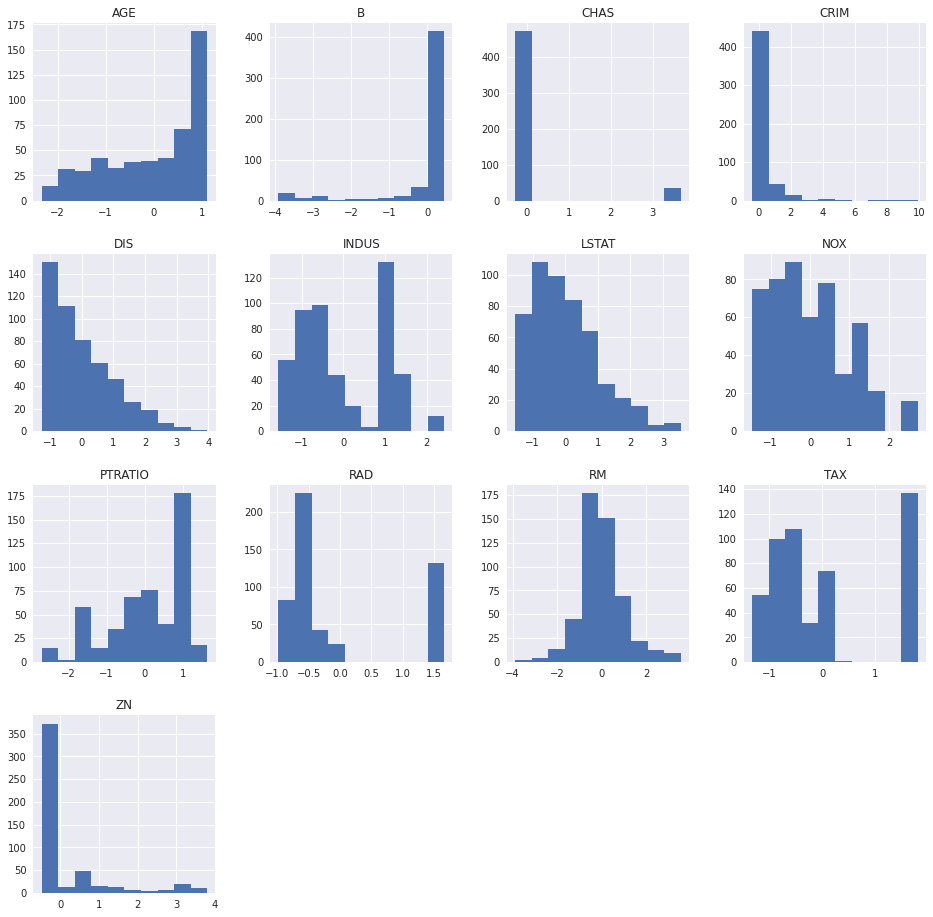

In [26]:
# Correlation matrix
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111)
correlations = X_train_df.corr(method='pearson')
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
plt.show()

In [29]:
if notifyStatus: status_notify('(AutoKeras Regression) Task 2 - Summarize and Visualize Data completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 3 - Pre-process Data

In [30]:
if notifyStatus: status_notify('(AutoKeras Regression) Task 3 - Pre-process Data has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

### 3.a) Feature Scaling

In [ ]:
# Compose pipeline for the numerical and categorical features
numeric_columns = X_train_df.select_dtypes(include=['int','float']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', preprocessing.PowerTransformer())
])
categorical_columns = X_train_df.select_dtypes(include=['object','category']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='NA')),
    ('onehot', preprocessing.OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

print("Number of numerical columns:", len(numeric_columns))
print("Number of categorical columns:", len(categorical_columns))
print("Total number of columns in the dataframe:", X_train_df.shape[1])

In [ ]:
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
#     ('cat', categorical_transformer, categorical_columns)
])
X_train = preprocessor.fit_transform(X_train_df)
print("Transformed X_train.shape:", X_train.shape)

In [ ]:
# # Apply binning techniques with continuous data (Block #1 of 1)
# discrete_feature = preprocessing.Binarizer(threshold=0.0)
# discrete_feature = preprocessing.KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='kmeans')
# feature_binned = discrete_feature.fit_transform(X_original[['old_feature1']])
# X_train_df['new_feature1'] = feature_binned
# X_train_df['new_feature1'] = X_train_df['new_feature1'].astype('category')
# X_train_df.drop(columns=['old_feature1', 'old_feature2'], inplace=True)
# X_train_df.head()

### 3.b) Training Data Balancing

In [ ]:
# Not applicable for this iteration of the project

In [ ]:
# Examine the target classes for imbalanced distribution
# Xy_original.groupby('targetVar').size()

In [ ]:
# # Perform SMOTE transformation on the training data (Block #1 of 2)
# X_train_imbal = X_train_df.values
# y_train_imbal = y_train_df.values.ravel()
# print("X_train_imbal.shape: {} y_train_imbal.shape: {}".format(X_train_imbal.shape, y_train_imbal.shape))

In [ ]:
# # Perform SMOTE transformation on the training data (Block #2 of 2)
# print ('Original class distribution - 1: {} | 0: {}'.format((y_train_imbal==1).sum(), (y_train_imbal==0).sum()))
# over_sample = SMOTE(sampling_strategy=0.05, random_state=seedNum)
# under_sample = RandomUnderSampler(sampling_strategy=1.0, random_state=seedNum)
# steps = [('o', over_sample), ('u', under_sample)]
# sample_pipeline = Pipeline(steps=steps)
# X_train, y_train = sample_pipeline.fit_resample(X_train_imbal, y_train_imbal)
# print ('Resampled class distribution - 1: {} | 0: {}'.format((y_train==1).sum(), (y_train==0).sum()))

### 3.c) Display the Final Datasets for Model-Building

In [ ]:
# Finalize the training dataset for the modeling activities
y_train = y_train_df.ravel()
print("X_train.shape: {} y_train.shape: {}".format(X_train.shape, y_train.shape))

In [ ]:
if notifyStatus: status_notify('(AutoKeras Regression) Task 3 - Pre-process Data completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 4 - Train and Evaluate Models

In [ ]:
if notifyStatus: status_notify('(AutoKeras Regression) Task 4 - Train and Evaluate Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [ ]:
# Define the default numbers of input/output for modeling
num_inputs = X_train.shape[1]

In [ ]:
# Define the baseline model for benchmarking
def create_nn_model(n_inputs=num_inputs, n_outputs=1, layer1_nodes=32, layer2_nodes=32, layer1_dropout=0, layer2_dropout=0, opt_param=default_optimizer, init_param=default_kernel_init):
    nn_model = keras.Sequential([
        keras.layers.Dense(layer1_nodes, input_shape=(n_inputs,), activation='relu', kernel_initializer=init_param),
        keras.layers.Dropout(layer1_dropout),
        keras.layers.Dense(layer2_nodes, activation='relu', kernel_initializer=init_param),
        keras.layers.Dropout(layer2_dropout),
        keras.layers.Dense(n_outputs, activation='sigmoid', kernel_initializer=init_param)
    ])
    nn_model.compile(loss=default_loss, optimizer=opt_param, metrics=default_metrics)
    return nn_model

In [ ]:
# Initialize the default model and get a baseline result
startTimeModule = datetime.now()
results = list()
iteration = 0
num_inputs, num_outputs = X_train.shape[1], 1
cv = RepeatedKFold(n_splits=n_folds, n_repeats=n_iterations, random_state=seedNum)
for train_ix, val_ix in cv.split(X_train):
    feature_train, feature_validation = X_train[train_ix], X_train[val_ix]
    target_train, target_validation = y_train[train_ix], y_train[val_ix]
    reset_random(seedNum)
    baseline_model = create_nn_model(n_inputs=num_inputs, n_outputs=num_outputs)
    baseline_model.fit(feature_train, target_train, epochs=default_epoch, batch_size=default_batch, verbose=0)
    model_metric = baseline_model.evaluate(feature_validation, target_validation, verbose=0)[1]
    iteration = iteration + 1
    print('Accuracy measurement from iteration %d >>> %.2f%%' % (iteration, model_metric*100))
    results.append(model_metric)
validation_score = np.mean(results)
print('Average model accuracy from all iterations: %.3f%% (%.3f)' % (validation_score*100, np.std(results)))
print('Total time for model fitting and cross validating:', (datetime.now() - startTimeModule))

In [ ]:
# Initialize the grid parameters for layer nodes
startTimeModule = datetime.now()
nodes_grid = [(48, 48), (64, 64), (96, 96), (128, 128), (192, 192)]
l1_dropout, l2_dropout = (0, 0)

# Build dataframe for reporting model performance summary
nodes_performance = pd.DataFrame(columns=['model_name', 'validation_score', 'layer1_nodes', 'layer2_nodes', 'layer1_dropout', 'layer2_dropout'])

serial_number = 0
for param in nodes_grid:
    startTimeIteration = datetime.now()
    serial_number = serial_number + 1
    model_name = "Model_" + str(serial_number).zfill(3)
    l1_nodes, l2_nodes = param
    print('Processing model %s with Layer 1: %d and Layer 2: %d nodes' % (model_name, l1_nodes, l2_nodes))
    results = list()
    iteration = 0
    num_inputs, num_outputs = X_train.shape[1], 1
    cv = RepeatedKFold(n_splits=n_folds, n_repeats=n_iterations, random_state=seedNum)
    for train_ix, val_ix in cv.split(X_train):
        feature_train, feature_validation = X_train[train_ix], X_train[val_ix]
        target_train, target_validation = y_train[train_ix], y_train[val_ix]
        reset_random(seedNum)
        node_grid_model = create_nn_model(n_inputs=num_inputs,
                                         n_outputs=num_outputs,
                                         layer1_nodes=l1_nodes,
                                         layer2_nodes=l2_nodes,
                                         opt_param=default_optimizer,
                                         init_param=default_kernel_init)
        node_grid_model.fit(feature_train, target_train, epochs=default_epoch, batch_size=default_batch, verbose=0)
        model_metric = node_grid_model.evaluate(feature_validation, target_validation, verbose=0)[1]
        iteration = iteration + 1
        print('Accuracy measurement from iteration %d >>> %.2f%%' % (iteration, model_metric))
        results.append(model_metric)
    validation_score = np.mean(results)
    print('Average model accuracy from all iterations: %.2f%% (%.3f)' % (validation_score*100, np.std(results)))
    print('Total time for model fitting and cross validating:', (datetime.now() - startTimeIteration))
    print()
    nodes_performance = nodes_performance.append({'model_name': model_name, 'validation_score': validation_score, 'layer1_nodes': l1_nodes, 'layer2_nodes': l2_nodes, 'layer1_dropout': l1_dropout, 'layer2_dropout': l2_dropout}, ignore_index=True)

nodes_performance.set_index('model_name', inplace=True)
print('Total time for performing search of the best layer node parameters:', (datetime.now() - startTimeModule))

In [ ]:
# Display the model performance summary
nodes_performance.sort_values(by=['validation_score'], ascending=False).head()

In [ ]:
# Initialize the grid parameters for the dropout ratio
startTimeModule = datetime.now()
l1_nodes = 64
l2_nodes = 64
l1_dropout_grid = [0, 0.25, 0.5]
l2_dropout_grid = [0, 0.5]

# Build dataframe for reporting model performance summary
dropout_performance = pd.DataFrame(columns=['model_name','validation_score','layer1_nodes','layer2_nodes','layer1_dropout','layer2_dropout'])

serial_number = 0
for l1_dropout in l1_dropout_grid:
    for l2_dropout in l2_dropout_grid:
        startTimeIteration = datetime.now()
        serial_number = serial_number + 1
        model_name = "Model_" + str(serial_number).zfill(3)
        print('Processing model %s with Layer 1: %d and Layer 2: %d nodes and dropout parameters of Layer 1: %.2f and Layer 2: %.2f' % (model_name, l1_nodes, l2_nodes, l1_dropout, l2_dropout))
        results = list()
        iteration = 0
        num_inputs, num_outputs = X_train.shape[1], 1
        cv = RepeatedKFold(n_splits=n_folds, n_repeats=n_iterations, random_state=seedNum)
        for train_ix, val_ix in cv.split(X_train):
            feature_train, feature_validation = X_train[train_ix], X_train[val_ix]
            target_train, target_validation = y_train[train_ix], y_train[val_ix]
            reset_random(seedNum)
            dropout_grid_model = create_nn_model(n_inputs=num_inputs,
                                                n_outputs=num_outputs,
                                                layer1_nodes=l1_nodes,
                                                layer2_nodes=l2_nodes,
                                                layer1_dropout=l1_dropout,
                                                layer2_dropout=l2_dropout,
                                                opt_param=default_optimizer,
                                                init_param=default_kernel_init)
            dropout_grid_model.fit(feature_train, target_train, epochs=default_epoch, batch_size=default_batch, verbose=0)
            model_metric = dropout_grid_model.evaluate(feature_validation, target_validation, verbose=0)[1]
            iteration = iteration + 1
            print('Accuracy measurement from iteration %d >>> %.2f%%' % (iteration, model_metric*100))
            results.append(model_metric)
        validation_score = np.mean(results)
        print('Average model accuracy from all iterations: %.2f%% (%.3f)' % (validation_score*100, np.std(results)))
        print('Total time for model fitting and cross validating:', (datetime.now() - startTimeIteration))
        print()
        dropout_performance = dropout_performance.append({'model_name': model_name, 'validation_score': validation_score, 'layer1_nodes': l1_nodes, 'layer2_nodes': l2_nodes, 'layer1_dropout': l1_dropout, 'layer2_dropout': l2_dropout}, ignore_index=True)

dropout_performance.set_index('model_name', inplace=True)
print('Total time for performing grid-search of the best dropout parameters:', (datetime.now() - startTimeModule))

In [ ]:
# Display the model performance summary
dropout_performance.sort_values(by=['validation_score'], ascending=False).head()

In [ ]:
# Spot-checking the models
fig = plt.figure(figsize=(16,9))
title = 'Model Comparison with Validation Metrics after ' + str(default_epoch) + ' epochs'
fig.suptitle(title)
ax1 = fig.add_subplot(111)
ax1.plot(dropout_performance['validation_score'], color='r', lw=2.)
plt.legend(['Validation'], loc='lower left')
plt.show()

In [ ]:
# Create the final model for evaluating the test dataset
model_to_use = 'Model_001'
final_l1_nodes = dropout_performance.loc[model_to_use]['layer1_nodes']
final_l2_nodes = dropout_performance.loc[model_to_use]['layer2_nodes']
final_l1_dropout = dropout_performance.loc[model_to_use]['layer1_dropout']
final_l2_dropout = dropout_performance.loc[model_to_use]['layer2_dropout']
final_optimizer = default_optimizer
final_kernel_init = default_kernel_init
final_epoch = default_epoch
final_batch = default_batch
num_inputs, num_outputs = X_train.shape[1], 1
print('Fitting final model with Layer 1: %d, Layer 2: %d with dropout parameters of Layer 1: %.2f, Layer 2: %.2f' % (final_l1_nodes, final_l2_nodes, final_l1_dropout, final_l2_dropout))
reset_random(seedNum)
final_model = create_nn_model(n_inputs=num_inputs,
                              n_outputs=num_outputs,
                              layer1_nodes=final_l1_nodes,
                              layer2_nodes=final_l2_nodes,
                              layer1_dropout=final_l1_dropout,
                              layer2_dropout=final_l2_dropout,
                              opt_param=final_optimizer,
                              init_param=final_kernel_init)
final_model.fit(X_train, y_train, epochs=final_epoch, batch_size=final_batch, verbose=1)

In [ ]:
# Summarize the final model
final_model.summary()

In [ ]:
# Display the configuration details of the final model
final_model.to_json()

In [38]:
if notifyStatus: status_notify('(AutoKeras Regression) Task 4 - Train and Evaluate Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 5 - Finalize Model and Present Analysis

In [39]:
if notifyStatus: status_notify('(AutoKeras Regression) Task 5 - Finalize Model and Present Analysis has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [40]:
# Apply the same data preparation steps to the test dataset
X_test = preprocessor.transform(X_test_df)
# Encode the target variable
y_test = y_test_df.ravel()
print("X_test.shape: {} y_test.shape: {}".format(X_test.shape, y_test.shape))

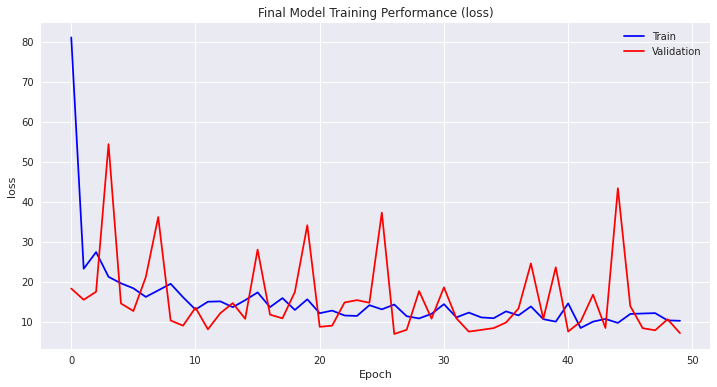

In [44]:
test_predictions = final_model.predict(X_test, batch_size=default_batch, verbose=1)
print('RMSE for the model is: ', math.sqrt(mean_squared_error(y_test, test_predictions)))
print('R2 for the model is: ', r2_score(y_test, test_predictions))

In [48]:
if notifyStatus: status_notify('(AutoKeras Regression) Task 5 - Finalize Model and Present Analysis completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [49]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:03:59.266850
